In [39]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy import sparse
from scipy.sparse import diags
from scipy.sparse.linalg import factorized
from PIL import Image

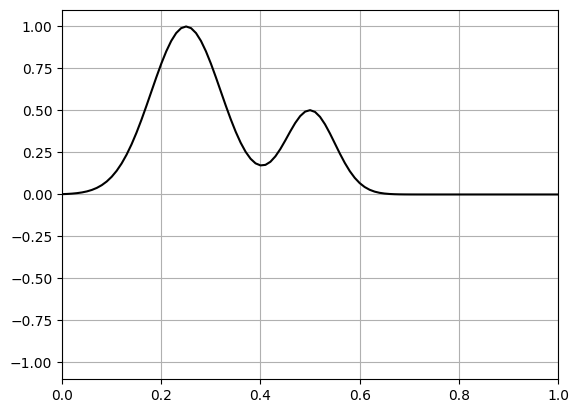

In [40]:
L = 1
T = 5

dx = 1e-2
dt = 1e-3

x = np.arange(0, L+dx, dx)
t = np.arange(0, T+dt, dt)

Nt, Nx = len(t), len(x)

def u0(x):
    return np.exp(-100*(x-L/4)**2) + np.exp(-200*(x-L/2)**2)*0.5

fig, ax = plt.subplots()
ax.plot(x, u0(x), color="black", lw=1.5)
ax.set_xlim(0, L)
ax.set_ylim(-1.1, 1.1)
ax.grid()


In [41]:
def save_gif_PIL(outfile, files, fps=5, loop=0):
    "Helper function for saving GIFs"
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=round(1000/fps), loop=loop)

def make_plot(save=False, file_name=f"PDE_solution.png", ti=0):
    "Helper function for plotting"
    fig, ax = plt.subplots()
    ax.plot(x, u[i, :], color="black", lw=1.5)
    ax.set_xlim(0, L)
    ax.set_ylim(-1.1, 1.1)
    ax.grid()
    ax.set_title(f"Time = {ti:.3f}s")
    if save:
        fig.savefig(file_name, bbox_inches="tight", pad_inches=0.1, dpi=100, facecolor="white")

In [ ]:
def D_t():
    D = 1/(12*dx) * diags([1, -8, 0, 8, -1], [-2, -1, 0, 1, 2], shape=(Nx, Nx)).toarray()
    D[0, [-2, -1]] = [1*1/(12*dx), -8*1/(12*dx)]
    D[1, [-1]] = [1*1/(12*dx)]
    D[-1, [0, 1]] = [8*1/(12*dx), -1*1/(12*dx)]
    D[-2, [0]] = [-1*1/(12*dx)]
    return sparse.csr_matrix(D)

def D2_t():
    d = 1/(dx**2 * 12)
    D = d * diags([-1, 16, -30, 16, -1], [-2, -1, 0, 1, 2], shape=(Nx, Nx)).toarray()
    D[0, [-2, -1]] = [-d, 16*d]
    D[1, [-1]] = [-d]
    D[-1, [0, 1]] = [16*d, -d]
    D[-2, [0]] = [-d]
    return sparse.csr_matrix(D)

u  = np.zeros((Nt, Nx))
c  = 1
a  = 1e-2
D1 = D_t()
D2 = D2_t()

def sovler_implicit(ui, uj):
    res = ui - uj + dt*0.5*(c*np.diag(ui)@(D1@ui) + c*np.diag(uj)@(D1@uj) - a*(D2@ui) - a*(D2@uj))
    return res.flatten()

In [43]:
for i, ti in enumerate(t):
    if i == 0:
        u[0, :] = u0(x)
    else:
        try:
            uj      = u[i-1, :]
            u[i, :] = fsolve(sovler_implicit, uj, args=(uj), xtol=1e-4)
        except Exception as e:
            print(f"fsolve failed at time step {i}: {e}")
            break
    
    if i % int(1/dt * 1e-1) == 0:
        print(f"Time {ti:.3f}s, max u = {np.max(np.abs(u[i, :])):.3f}")


Time 0.000s, max u = 1.000
Time 0.100s, max u = 0.840
Time 0.200s, max u = 0.740
Time 0.300s, max u = 0.675
Time 0.400s, max u = 0.632
Time 0.500s, max u = 0.600
Time 0.600s, max u = 0.572
Time 0.700s, max u = 0.548
Time 0.800s, max u = 0.525
Time 0.900s, max u = 0.505
Time 1.000s, max u = 0.485
Time 1.100s, max u = 0.468
Time 1.200s, max u = 0.452
Time 1.300s, max u = 0.438
Time 1.400s, max u = 0.424
Time 1.500s, max u = 0.412
Time 1.600s, max u = 0.401
Time 1.700s, max u = 0.391
Time 1.800s, max u = 0.382
Time 1.900s, max u = 0.373
Time 2.000s, max u = 0.365
Time 2.100s, max u = 0.358
Time 2.200s, max u = 0.352
Time 2.300s, max u = 0.345
Time 2.400s, max u = 0.340
Time 2.500s, max u = 0.334
Time 2.600s, max u = 0.329
Time 2.700s, max u = 0.325
Time 2.800s, max u = 0.321
Time 2.900s, max u = 0.317
Time 3.000s, max u = 0.313
Time 3.100s, max u = 0.309
Time 3.200s, max u = 0.306
Time 3.300s, max u = 0.303
Time 3.400s, max u = 0.300
Time 3.500s, max u = 0.297
Time 3.600s, max u = 0.294
T

In [44]:
import os
import shutil

folder_path="plots"
for item in os.listdir(folder_path):
    item_path = os.path.join(folder_path, item)
    try:
        if os.path.isfile(item_path) or os.path.islink(item_path):
            os.unlink(item_path)  # Remove file or symbolic link
        elif os.path.isdir(item_path):
            shutil.rmtree(item_path)  # Remove subdirectory and its contents
    except Exception as e:
        print(f"Failed to delete {item_path}. Reason: {e}")

In [46]:
files = []
fps   = 20
frame_indicies = np.linspace(0, Nt-1, int(fps*T*2), dtype=int)
N_frames = len(frame_indicies)
for i, index in enumerate(frame_indicies):
    tj = t[index]
    file = f"plots/PDE_sol_{tj:.5f}.png"
    make_plot(save=True, file_name=file, ti=tj)
    files.append(file)
    plt.close("all")
    print(f"{i}/{N_frames}")
    
save_gif_PIL("PDE_solution.gif", files, fps=fps, loop=0)

0/200
1/200
2/200
3/200
4/200
5/200
6/200
7/200
8/200
9/200
10/200
11/200
12/200
13/200
14/200
15/200
16/200
17/200
18/200
19/200
20/200
21/200
22/200
23/200
24/200
25/200
26/200
27/200
28/200
29/200
30/200
31/200
32/200
33/200
34/200
35/200
36/200
37/200
38/200
39/200
40/200
41/200
42/200
43/200
44/200
45/200
46/200
47/200
48/200
49/200
50/200
51/200
52/200
53/200
54/200
55/200
56/200
57/200
58/200
59/200
60/200
61/200
62/200
63/200
64/200
65/200
66/200
67/200
68/200
69/200
70/200
71/200
72/200
73/200
74/200
75/200
76/200
77/200
78/200
79/200
80/200
81/200
82/200
83/200
84/200
85/200
86/200
87/200
88/200
89/200
90/200
91/200
92/200
93/200
94/200
95/200
96/200
97/200
98/200
99/200
100/200
101/200
102/200
103/200
104/200
105/200
106/200
107/200
108/200
109/200
110/200
111/200
112/200
113/200
114/200
115/200
116/200
117/200
118/200
119/200
120/200
121/200
122/200
123/200
124/200
125/200
126/200
127/200
128/200
129/200
130/200
131/200
132/200
133/200
134/200
135/200
136/200
137/200
138/20